In [2]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Q1: Read in gold data and the labels data

In [3]:
gold = pd.read_csv('gold.txt', sep='\t+', engine='python', header=None, names=['url', 'category'])
gold[:5]

,url,category
0,http://0800-horoscope.com,G
1,http://18games.net,X
2,http://1pixelout.net,G
3,http://1porno.com/004/teens/index.html,X
4,http://1stpussy.com/005/16/index.html,X


In [4]:
labels = pd.read_csv('labels.txt', sep='\t+', engine='python', header=None, names=['turk', 'url', 'category'])
labels[:5]

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G


### Q2: Split the labels DataFrame into two: labels_on_gold and labels_unknown

In [5]:
def is_gold_url(u):
    return u in gold['url'].values
mask = (labels['url'].map(is_gold_url))
labels_on_gold = labels[mask]
labels_unknown = labels[~mask]
print '{} rows with labels, {} rows without labels'.format(len(labels_on_gold), len(labels_unknown))

3324 rows with labels, 89397 rows without labels


In [6]:
len(labels[~labels['url'].isin(gold['url'].values)])

89397

### Q3: Create a rater_goodness dataframe indexed by turk, and two columns containing the number of ratings and the average correctness of ratings for each turk (both on gold set urls).

In [7]:
merged = pd.merge(labels_on_gold, gold, left_on='url', right_on='url', suffixes=['_actual', '_truth'])
merged[:5]

,turk,url,category_actual,category_truth
0,A1253FXHCZ9CWM,http://0800-horoscope.com,G,G
1,A153PKAL7OAY36,http://0800-horoscope.com,G,G
2,A1FV9SAPL5C6KY,http://0800-horoscope.com,G,G
3,A1JTOT0DWM6QGL,http://0800-horoscope.com,G,G
4,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G,G


In [8]:
def is_match(b):
    if b == True:
        return 1
    else:
        return 0
merged['match'] = (merged['category_actual'] == merged['category_truth']).map(is_match)
merged[:5]

,turk,url,category_actual,category_truth,match
0,A1253FXHCZ9CWM,http://0800-horoscope.com,G,G,1
1,A153PKAL7OAY36,http://0800-horoscope.com,G,G,1
2,A1FV9SAPL5C6KY,http://0800-horoscope.com,G,G,1
3,A1JTOT0DWM6QGL,http://0800-horoscope.com,G,G,1
4,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G,G,1


In [9]:
rater_goodness = merged.groupby('turk')['match'].agg(['count', 'mean'])
print len(rater_goodness)
rater_goodness[:5]

269


,count,mean
turk,,
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333


### Q4: Calculate the odds ratio for each turk.

In [8]:
rater_goodness['odds'] = rater_goodness['mean'] / (1.001 - rater_goodness['mean'])
print len(rater_goodness)
rater_goodness[:5]

269


,count,mean,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251


### Q5: List the top 10 most accurate turks with at least 20 gold-set ratings.

In [17]:
rater_goodness[rater_goodness['count'] >= 20].sort_values(by='mean', ascending=False)[:10]

,count,mean,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


### Q6: Is number of ratings related to accuracy?

0.0452923828048
-0.0819193561196


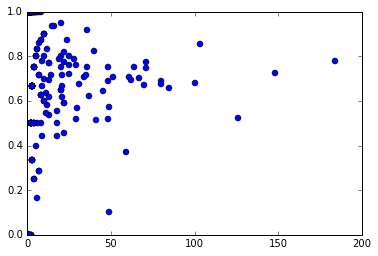

In [18]:
plot(rater_goodness['count'], rater_goodness['mean'], marker='o', linestyle='None')
print rater_goodness['count'].corr(rater_goodness['mean'])
print rater_goodness['count'].corr(rater_goodness['mean'], method='spearman')

### Q7: For each url u _not_ in the gold set, and for each category c, calculate the product of odds of all turks who (a) rated url u as category c, AND (b) have rated more gold set urls than 75% of all turks. Call this product of odds the _overall odds_.

In [19]:
merged2 = pd.merge(labels_unknown, rater_goodness.reset_index(), left_on='turk', right_on='turk')
merged2[:5]

,turk,url,category,count,mean,odds
0,A1OT3A29R9N1DG,http://000.cc,P,8,0.5,0.998004
1,A1OT3A29R9N1DG,http://1centemails.com,G,8,0.5,0.998004
2,A1OT3A29R9N1DG,http://24hfx.com,P,8,0.5,0.998004
3,A1OT3A29R9N1DG,http://265e.com,P,8,0.5,0.998004
4,A1OT3A29R9N1DG,http://30gh.com,G,8,0.5,0.998004


In [20]:
pv1 = pd.pivot_table(merged2[merged2['count'] > rater_goodness['count'].quantile(0.75)],
                     index='category',
                     columns='url',
                     values='odds',
                     aggfunc=prod).fillna(0.0)
pv1[:5]

url,http://0-101.net,http://000.cc,http://0000.jp,http://000relationships.com,http://000vitamins.com,http://000webhost.com,http://003my.com,http://007absolutehardcore.com/early_cumshots/index.html,http://007swz.cn,http://01768.com,...,http://zucaiba.com,http://zumin-ads.com,http://zune.net,http://zvezdanews.ru,http://zwame.pt,http://zwinky.com,http://zylom.com,http://zynga.com,http://zz868.com,http://zzx.cc
category,,,,,,,,,,,,,,,,,,,,,
G,2.155963,1.460583,14.488244,5.681060,3.784982,11.159502,4.91204,0.000000,1.393883,1.393883,...,1.432532,2.779429,20.209842,5.831416,8.62379,16.141443,1.735526,3.704611,1.047852,1.330229
P,0.000000,0.000000,0.000000,1.851852,0.000000,0.000000,0.00000,3.346522,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.851852,0.000000
R,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,12.290450,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
X,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,293.252871,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.620746


### Q8: Create a DataFrame whose index is urls not in the gold set, and with two columns called _top category_ and _top odds_. The _top category_ should be the category with the highest overall odds for that url, and the _top odds_ should be the overall value for that _top category_. Call this **result_75**.

In [24]:
results_df = DataFrame({'top category':pv1.idxmax(), 'top odds':pv1.max()}, index=pv1.columns.values)
results_df[:10]

,top category,top odds
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,5.681060
http://000vitamins.com,G,3.784982
http://000webhost.com,G,11.159502
http://003my.com,G,4.912040
http://007absolutehardcore.com/early_cumshots/index.html,X,293.252871
http://007swz.cn,G,1.393883
http://01768.com,G,1.393883


### Q9: Repeat Q7 and Q8, but replacing "75%" by "25%" in the description of Q7 (i.e., we also consider turks who have far fewer gold set ratings). Call this result_25. Create a DataFrame where both the index and the columns are the various categories, and the cells contain the number of urls with these as the top categories according to result_75 and result_25.

For example, the cell corresponding to the row "category=R" and the column "category=G" would be the number of urls that were predicted to be R by result_75 but predicted to be G by result_25.

In [22]:
pv2 = pd.pivot_table(merged2[merged2['count'] >= rater_goodness['count'].quantile(0.25)],
                     index='category',
                     columns='url',
                     values='odds',
                     aggfunc=prod).fillna(0.0)
results_df2 = DataFrame({'top category':pv2.idxmax(), 'top odds':pv2.max()}, index=pv2.columns.values)

In [23]:
results_merged = pd.merge(results_df, results_df2, left_index=True, right_index=True, suffixes=['_75', '_25'])
print len(results_merged[results_merged['top category_75'] != results_merged['top category_25']]) * 1.0 / len(results_merged)
pd.crosstab(results_merged['top category_75'], results_merged['top category_25'])

0.17794533459


top category_25,G,P,R,X
top category_75,,,,
G,7920,836,297,250
P,230,268,58,27
R,21,36,118,33
X,61,7,32,416


The most errors are made when result_75 predicts G but results_25 predicts P.